In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
url = 'https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/flights.csv'
airport_data = pd.read_csv(url)

### • Может ли самолёт отправиться сильно раньше времени отправления? Насколько?

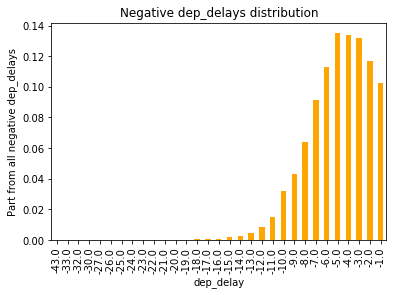

In [89]:
#посмотрим, бывают ли большие отрицательные задержки отправления

min_del = airport_data[airport_data['dep_delay']<0]
min_del = min_del.groupby('dep_delay').count()
total = min_del['Unnamed: 0'].sum().sum()
a = min_del.sort_values(by='dep_delay')['Unnamed: 0'].apply(lambda x: x/total)
a.plot(x='dep_delay', y='Unnamed: 0', kind='bar', color = 'orange')
plt.ylabel('Part from all negative dep_delays')
plt.title('Negative dep_delays distribution')
plt.show()

Вылета раньше, чем за 14 минут от отправления практически не бывает. Хорошая новость для тех, кто приезжает в аэропорт впритык.

### • Как зависят задержки отправления от времени суток?

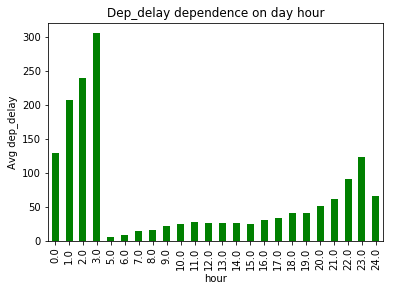

In [90]:
#рассмотрим только положительные задержки и то, как они зависят от времени суток
del_t = airport_data[airport_data['dep_delay']>=0]
del_t = del_t.groupby('hour').mean()['dep_delay']
del_t.plot(kind='bar', color='green')
plt.ylabel('Avg dep_delay')
plt.title('Dep_delay dependence on day hour')
plt.show()

Таким образом, в ночное время с 0:00 до 3:00 наблюдаются самые большие задержки

### • Есть ли рейсы, у которых постоянно происходит задержка? 

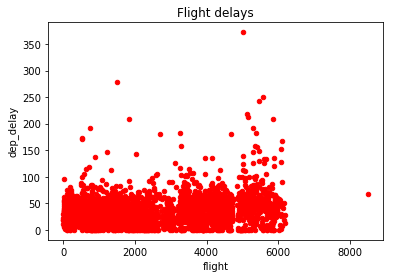

In [91]:
#поскольку задержка вылета в основном влечет задержку прилёта, поэтому будем оценивать только задержки вылетов
flight_del = airport_data
flight_del.loc[flight_del.dep_delay.between(-15,0), 'dep_delay'] = 0
flight_del = flight_del[(flight_del.dep_delay>=0)&(flight_del.arr_delay>=0)].groupby('flight').mean().reset_index()[['flight','dep_delay','arr_delay']]
flight_del = flight_del.sort_values('dep_delay')
flight_del.plot(x='flight', y='dep_delay', kind='scatter', color='red')
plt.title('Flight delays')
plt.show()

Видно, что есть маршруты, по которым время задержки много выше среднего. Скорее всего это очень редкие маршруты. Но не будем углубляться.
Также видно, что большая часть маршрутов склонна к задержкам.

In [ ]:
#ВСПОМОГАТЕЛЬНЫЙ ПРИМЕР
#airport_data.groupby(['origin', 'dest']).size().to_frame('size').reset_index().sort_values(['origin', 'dest'], ascending=[True, False])

### • Посмотрим на зависимость задержки прилёта от дистанции полёта

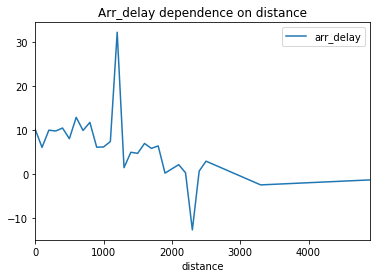

In [92]:
#Зависимость задержки прилета от дистанции
dist_del = airport_data
dist_del['distance'] = dist_del['distance'].apply(lambda x: (x//100)*100)
dist_del = dist_del.groupby('distance').mean().reset_index()[['distance','arr_delay']]
dist_del.plot(x='distance', y='arr_delay', kind='line')
plt.title('Arr_delay dependence on distance')
plt.show()

Видно, что примерно при увеличении дистанции прилёт происходит более точно.

### • Зависит ли среднее время задержки от перевозчика?

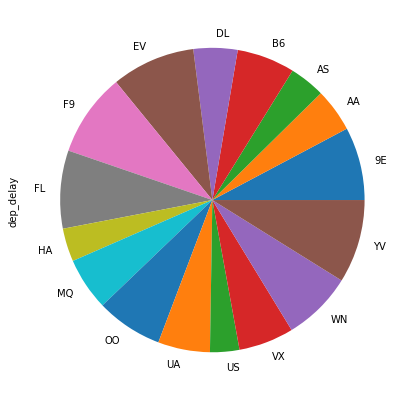

In [93]:
#среднее время задержки в зависимости от перевозчика
carr_avg = airport_data
carr_avg.loc[carr_avg.dep_delay.between(-15,0), 'dep_delay'] = 0
carr_avg = carr_avg.groupby('carrier').mean()['dep_delay']
carr_avg.plot.pie(y='dep_delay', figsize=(7, 7))
plt.show()

AS, US выделяются относительно небольим временем задержки. F9, EV, YV - наоборот

### • Вероятность задержки каждого перевозчика

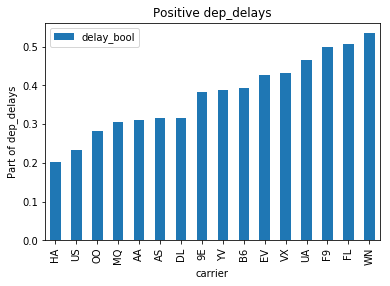

In [94]:
#отношение задержек ко всем перелетам по перевозчикам
carr_count = airport_data
carr_count['delay_bool']=carr_count['dep_delay'].apply(lambda x: 1 if x>0 else 0)
carr_count = carr_count.groupby('carrier').mean()['delay_bool'].reset_index().sort_values(['delay_bool'])
carr_count.plot(x='carrier', y='delay_bool', kind='bar')
plt.title('Positive dep_delays')
plt.ylabel('Part of dep_delays')
plt.show()

US лидирует и в этом исследовании:задержки случаются довольно редко. F9 отстаёт и здесь: вероятность задержки почти 0.5

# Далее "притянем" погодные условия

In [95]:
weather = pd.read_csv('https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/weather.csv')
weather = weather[weather['origin'] == 'EWR']

In [96]:
air_weather = airport_data.merge(weather, left_on=['year','month','day','hour'], right_on=['year','month','day','hour'], how='left').dropna(axis='index')
#pd.options.display.max_columns = None
#display(air_weather)


In [97]:
#Для того, чтоб внутри группы по видимости было больше данных
air_weather['visib']=air_weather['visib'].apply(lambda x: int(x))

### • Как видимость влияет на задержку прилёта?

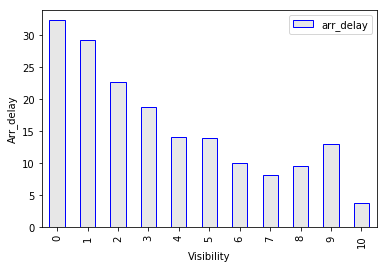

In [98]:
#Задержка прилета от видимостии
vis = air_weather.groupby('visib').mean()['arr_delay'].reset_index()
vis.plot(x='visib', y='arr_delay', kind='bar', color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
plt.xlabel('Visibility')
plt.ylabel('Arr_delay')
plt.show()

Чем хуже видимость, тем больше задержка прилёта

### • Как зависити задержка отправления от силы порыва ветра?

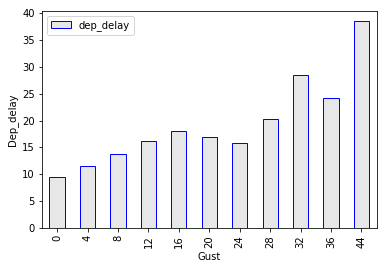

In [99]:
#задержка отправления от силы порыва 
gust = air_weather
gust['wind_gust']=gust['wind_gust'].apply(lambda x: int(x/4)*4)
gust = gust.groupby('wind_gust').mean()['dep_delay'].reset_index()
gust = gust[gust.wind_gust != 1204]
gust.plot(x='wind_gust', y='dep_delay', kind='bar', color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
plt.xlabel('Gust')
plt.ylabel('Dep_delay')
plt.show()
#air_weather.groupby('wind_gust').size().to_frame('size')

Чем выше сила порывов, тем больше задержка

### • Как зависит задержка отправления от скорости ветра?

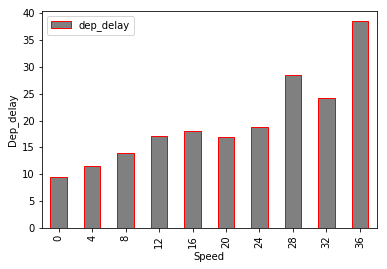

In [100]:
#задержка отправления от скорости ветра 
speed = air_weather
speed['wind_speed']=speed['wind_speed'].apply(lambda x: int(x/4)*4)
speed = speed.groupby('wind_speed').mean()['dep_delay'].reset_index()
speed = speed[speed.wind_speed != 1048]
speed.plot(x='wind_speed', y='dep_delay', kind='bar', color=(0.5, 0.5, 0.5, 1),  edgecolor='red')
plt.xlabel('Speed')
plt.ylabel('Dep_delay')
plt.show()
#air_weather.groupby('wind_gust').size().to_frame('size')

Чем выше скорость ветра, тем больше задержка отправления

### • Какие перевозчики лучше всего готовы к плохой видимости?

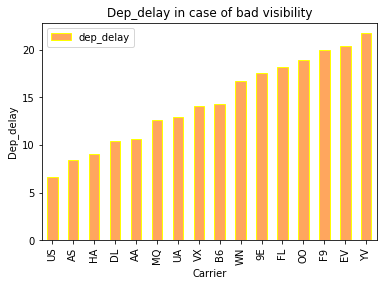

In [101]:
#Хочется узнать, какие перевозчики оказываются более готовыми к плохoй видимости
carr_w = air_weather[air_weather.visib <=5]
carr_w = air_weather.groupby('carrier').mean()['dep_delay'].reset_index().sort_values('dep_delay')
carr_w.plot(x='carrier', y='dep_delay', kind='bar', color=(1, 0.5, 0.1, 0.7),  edgecolor='yellow')
plt.xlabel('Carrier')
plt.ylabel('Dep_delay')
plt.title('Dep_delay in case of bad visibility')
plt.show()

Ситуация похожа на "Вероятность задержки перевозчика". Из заметных совпадений: US оказались более собранными и не задерживают отправление в случае плохой видимости. F9 - наоборот.